In [1]:
import pandas as pd

In [5]:
df=pd.read_csv("C:/Users/Hiruni/OneDrive/Desktop/ml_project3/thyroid_cancer_risk_data.csv")


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 212691 non-null  int64  
 1   Gender              212691 non-null  object 
 2   Country             212691 non-null  object 
 3   Ethnicity           212691 non-null  object 
 4   Family_History      212691 non-null  object 
 5   Radiation_Exposure  212691 non-null  object 
 6   Iodine_Deficiency   212691 non-null  object 
 7   Smoking             212691 non-null  object 
 8   Obesity             212691 non-null  object 
 9   Diabetes            212691 non-null  object 
 10  TSH_Level           212691 non-null  float64
 11  T3_Level            212691 non-null  float64
 12  T4_Level            212691 non-null  float64
 13  Nodule_Size         212691 non-null  float64
 14  Diagnosis           212691 non-null  object 
dtypes: float64(4), int64(1), object(10

In [9]:
import pandas as pd

# List of categorical variables
one_hot_cols = ['Country', 'Ethnicity']  # OHE
binary_cols = ['Gender', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 
               'Smoking', 'Obesity', 'Diabetes', 'Diagnosis']  # Binary

# Apply One-Hot Encoding
df_ohe = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)  # drop_first=True to avoid dummy variable trap

# Define manual binary mapping
binary_mapping = {"No": 0, "Yes": 1, "Male": 0, "Female": 1, "Benign": 0, "Malignant": 1}

# Apply mapping to binary categorical columns
df_ohe[binary_cols] = df_ohe[binary_cols].replace(binary_mapping)

# Display the transformed dataset
print(df_ohe.head())


C:\Users\Hiruni\AppData\Local\Temp\ipykernel_12884\4244592123.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ohe[binary_cols] = df_ohe[binary_cols].replace(binary_mapping)


   Age  Gender  Family_History  Radiation_Exposure  Iodine_Deficiency  \
0   66       0               0                   1                  0   
1   29       0               0                   1                  0   
2   86       0               0                   0                  0   
3   75       1               0                   0                  0   
4   35       1               1                   1                  0   

   Smoking  Obesity  Diabetes  TSH_Level  T3_Level  ...  Country_Japan  \
0        0        0         0       9.37      1.67  ...          False   
1        0        0         0       1.83      1.73  ...          False   
2        0        0         0       6.26      2.59  ...          False   
3        0        0         0       4.10      2.62  ...          False   
4        0        0         0       9.10      2.11  ...          False   

   Country_Nigeria  Country_Russia  Country_South Korea  Country_UK  \
0            False            True           

In [11]:
from sklearn.model_selection import train_test_split

# Separate features (X) and response variable (y)
X = df_ohe.drop(columns=['Diagnosis'])  # Features
y = df_ohe['Diagnosis']  # Response variable

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the splits
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (170152, 25), Test set: (42539, 25)


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [15]:
# Apply SMOTE to balance the target variable `y` in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution before and after SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

C:\Users\Hiruni\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Class distribution before SMOTE:
Diagnosis
0    130581
1     39571
Name: count, dtype: int64

Class distribution after SMOTE:
Diagnosis
1    130581
0    130581
Name: count, dtype: int64


In [17]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns to scale (modify as needed)
numerical_cols = ['Age', 'TSH_Level', 'T4_Level', 'T3_Level', 'Nodule_Size']  # Add other numerical columns as needed

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the features
X_train_smote[numerical_cols] = scaler.fit_transform(X_train_smote[numerical_cols])

# Apply the same transformation to the test set
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Check the scaled features (optional)
print(X_train_smote[numerical_cols].head())


        Age  TSH_Level  T4_Level  T3_Level  Nodule_Size
0 -1.611280   0.484948  0.664400  0.131257     0.168532
1  1.254895   0.222220  1.333284  1.552875    -0.797256
2  1.254895   0.358838  1.314704 -1.610226     0.525453
3  0.746380  -0.022993  1.542310 -0.081986     1.330277
4 -0.455564   0.978876  0.548274  1.623956    -1.623075


In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Perform Grid Search CV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=1
)

rf_grid_search.fit(X_train_smote, y_train_smote)
best_rf = rf_grid_search.best_estimator_

# Perform Grid Search CV for XGBoost
xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=1
)

xgb_grid_search.fit(X_train_smote, y_train_smote)
best_xgb = xgb_grid_search.best_estimator_



Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\Hiruni\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [27]:
# Print best parameters and scores
print("📌 Best Parameters for Random Forest:")
print(rf_grid_search.best_params_)
print("Best F1 Score (CV):", rf_grid_search.best_score_)

print("\n📌 Best Parameters for XGBoost:")
print(xgb_grid_search.best_params_)
print("Best F1 Score (CV):", xgb_grid_search.best_score_)

📌 Best Parameters for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score (CV): 0.7794497666484407

📌 Best Parameters for XGBoost:
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best F1 Score (CV): 0.7075118185809094


In [29]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_smote, y_train_smote)

# Predictions on train set
y_pred_train_log_reg = log_reg.predict(X_train_smote)
y_pred_train_rf = best_rf.predict(X_train_smote)
y_pred_train_xgb = best_xgb.predict(X_train_smote)

# Predictions on test set
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report

# Evaluate on the training set
print("Logistic Regression Evaluation on Train Set:")
print(classification_report(y_train_smote, y_pred_train_log_reg))

print("Random Forest Evaluation on Train Set:")
print(classification_report(y_train_smote, y_pred_train_rf))

print("XGBoost Evaluation on Train Set:")
print(classification_report(y_train_smote, y_pred_train_xgb))


print("Logistic Regression Evaluation on Test Set:")
print(classification_report(y_test, y_pred_log_reg))

print("Random Forest (Tuned) Evaluation on Test Set:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost (Tuned) Evaluation on Test Set:")
print(classification_report(y_test, y_pred_xgb))

Logistic Regression Evaluation on Train Set:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72    130581
           1       0.73      0.68      0.70    130581

    accuracy                           0.71    261162
   macro avg       0.71      0.71      0.71    261162
weighted avg       0.71      0.71      0.71    261162

Random Forest Evaluation on Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130581
           1       1.00      1.00      1.00    130581

    accuracy                           1.00    261162
   macro avg       1.00      1.00      1.00    261162
weighted avg       1.00      1.00      1.00    261162

XGBoost Evaluation on Train Set:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81    130581
           1       0.87      0.69      0.77    130581

    accuracy                           0.79    261162
   macro av

<Figure size 1000x600 with 0 Axes>

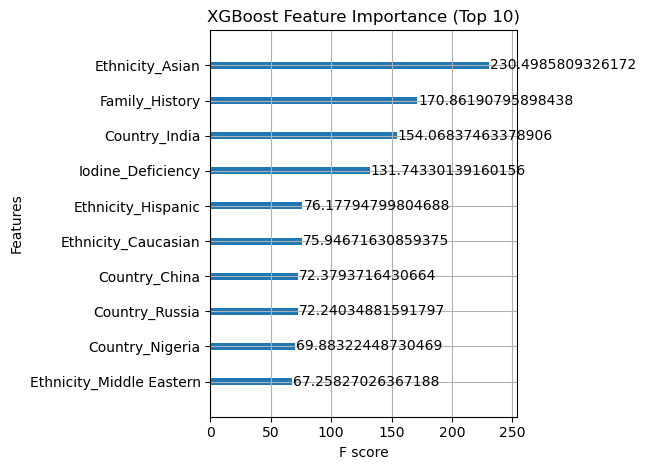

In [35]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10, importance_type='gain', title='XGBoost Feature Importance (Top 10)')
plt.tight_layout()
plt.show()


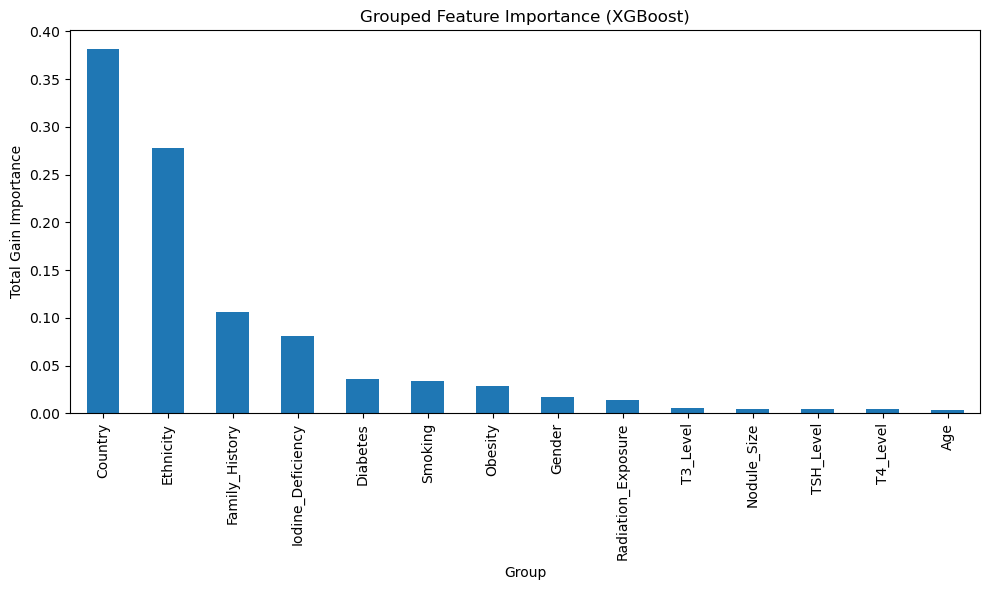

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances as a pandas Series
importances = best_xgb.feature_importances_
features = X_train_smote.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Grouping by 'Country' and 'Ethnicity'
importance_df['Group'] = importance_df['Feature'].apply(
    lambda x: 'Country' if x.startswith('Country_') else (
              'Ethnicity' if x.startswith('Ethnicity_') else x))

# Summing importance by group
grouped_importance = importance_df.groupby('Group')['Importance'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
grouped_importance.plot(kind='bar')
plt.title('Grouped Feature Importance (XGBoost)')
plt.ylabel('Total Gain Importance')
plt.tight_layout()
plt.show()


In [15]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


# Fit Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_smote, y_train_smote)

# Predictions on train set

y_pred_train_dt = dt_model.predict(X_train_smote)

# Predictions on test set

y_pred_dt = dt_model.predict(X_test)


print("Decision Tree Evaluation on Train Set:")
print(classification_report(y_train_smote, y_pred_train_dt))


print("Decision Tree Evaluation on Test Set:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Evaluation on Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130581
           1       1.00      1.00      1.00    130581

    accuracy                           1.00    261162
   macro avg       1.00      1.00      1.00    261162
weighted avg       1.00      1.00      1.00    261162

Decision Tree Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     32615
           1       0.34      0.47      0.39      9924

    accuracy                           0.66     42539
   macro avg       0.58      0.60      0.58     42539
weighted avg       0.71      0.66      0.68     42539



In [19]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC(random_state=42, max_iter=10000)
linear_svm.fit(X_train_smote, y_train_smote)

y_pred_train_svm = linear_svm.predict(X_train_smote)
y_pred_svm = linear_svm.predict(X_test)



In [21]:
from sklearn.metrics import classification_report

# Evaluation on Train Set
print("Linear SVM Evaluation on Train Set:")
print(classification_report(y_train_smote, y_pred_train_svm))

# Evaluation on Test Set
print("Linear SVM Evaluation on Test Set:")
print(classification_report(y_test, y_pred_svm))



Linear SVM Evaluation on Train Set:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72    130581
           1       0.73      0.68      0.70    130581

    accuracy                           0.71    261162
   macro avg       0.72      0.71      0.71    261162
weighted avg       0.72      0.71      0.71    261162

Linear SVM Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     32615
           1       0.33      0.40      0.36      9924

    accuracy                           0.67     42539
   macro avg       0.57      0.58      0.57     42539
weighted avg       0.70      0.67      0.68     42539

